In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pickle
import scipy
import scipy.integrate as integrate
import time 
from tqdm import tqdm

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import BaseModel

from delfi.distribution.mixture import MoG
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 18,
              'legend.frameon': False,
                      'axes.titlesize': 21,
                      'axes.labelsize': 19,
                      'xtick.labelsize': 15,
                      'ytick.labelsize': 15,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

## Bayesian model comparison with Gaussian vs. Laplace model 

The task is to decide whether the observed data comes from Normal or from a Laplace distribution. 

The difficulty in this task comes only from the amount of data available. The priors should be chosen in a way that they do not favor one or the other model

### Visulization 

In [3]:
# thetas to evaluate 
thetas = np.linspace(-10, 10, 1000)

# example background model 
example_m0 = scipy.stats.norm(0, 2)
# signal model 
example_m1 = scipy.stats.laplace(0, 2)
# draw example observed data 
xo = example_m1.rvs(1)

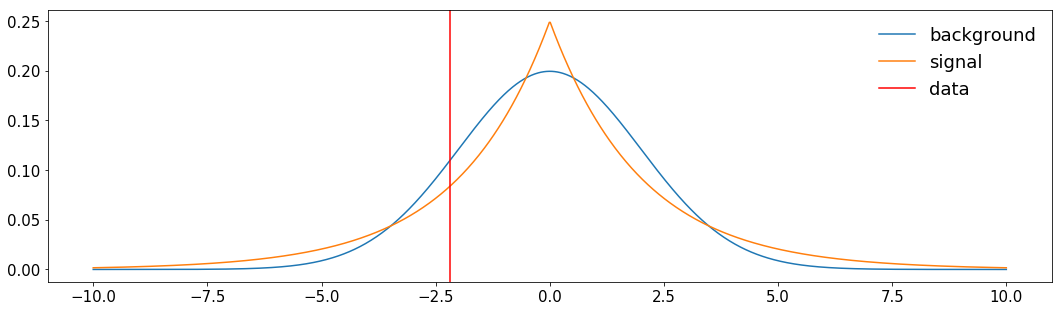

In [4]:
plt.plot(thetas, example_m0.pdf(thetas), label='background')
plt.plot(thetas, example_m1.pdf(thetas), label='signal')
plt.axvline(xo, label='data', color='r')
plt.legend();

## Set up models

In [5]:
class GaussianModel(BaseModel):
    def __init__(self, mu, dim_param=1, sample_size=10, n_workers=1, seed=None):
        super().__init__(dim_param=dim_param, sample_size=sample_size, n_workers=n_workers, seed=seed)
        self.mu = mu
        self.posterior = None

    def gen_single(self, params):
        # in multiprocessing the parameter vector additionally contains a seed
        if self.run_parallel:
            scale, seed = params
            self.rng.seed(int(seed))
        else:
            scale = params
        return self.rng.normal(loc=self.mu, scale=scale, size=self.sample_size)
    
class LaplaceModel(BaseModel): 
    def __init__(self, mu, dim_param=1, sample_size=10, n_workers=1, seed=None):
        super().__init__(dim_param=dim_param, sample_size=sample_size, n_workers=n_workers, seed=seed)
        self.mu = mu
        self.posterior = None

    def gen_single(self, params):
        # in multiprocessing the parameter vector additionally contains a seed
        if self.run_parallel:
            scale, seed = params
            self.rng.seed(int(seed))
        else:
            scale = params
        return self.rng.laplace(loc=self.mu, scale=scale, size=self.sample_size)

In [6]:
def summary_stats_laplace_normal(samples): 
    # return the first n moments 
    return np.array([np.mean(samples, axis=1), np.std(samples, axis=1), 
                     scipy.stats.skew(samples, axis=1), 
                     scipy.stats.kurtosis(samples, axis=1)]).T

In [7]:
sample_size = 50
ntrain = 500000
ntest = 100

# background model prior 
prior_m0 = scipy.stats.invgamma(2)
# signal model prior 
prior_m1 = scipy.stats.invgamma(2)

# models 
m0 = GaussianModel(mu=0, sample_size=sample_size)
m1 = LaplaceModel(mu=0, sample_size=sample_size)

## Generate parameters from the priors 

In [8]:
n = ntrain + ntest
params_m0 = np.sqrt(prior_m0.rvs(size=int(n / 2)))
params_m1 = prior_m1.rvs(size=int(n / 2))

## Generate data from models and calculate summary stats, prepare test data 

In [9]:
data_m0 = m0.gen(params_m0)
data_m1 = m1.gen(params_m1)

In [10]:
# shuffle and set up model index target vector 
x_all = np.vstack((data_m0, data_m1))

# define model indices
m_all = np.hstack((np.zeros(data_m0.shape[0]), np.ones(data_m1.shape[0]))).squeeze().astype(int)

# get shuffled indices 
shuffle_indices = np.arange(n)
np.random.shuffle(shuffle_indices)

# shuffle the data 
x_all = x_all[shuffle_indices, ]
m_all = m_all[shuffle_indices].tolist()

x, xtest = x_all[:ntrain, :], x_all[ntrain:, :]
m, mtest = m_all[:ntrain], m_all[ntrain:]

In [11]:
# calculate summary stats
sx = summary_stats_laplace_normal(x)
sx_test = summary_stats_laplace_normal(xtest)
# use training norm to normalize test data 
sx_zt, training_norm = normalize(sx)
sx_test_zt, _ = normalize(sx_test, training_norm)

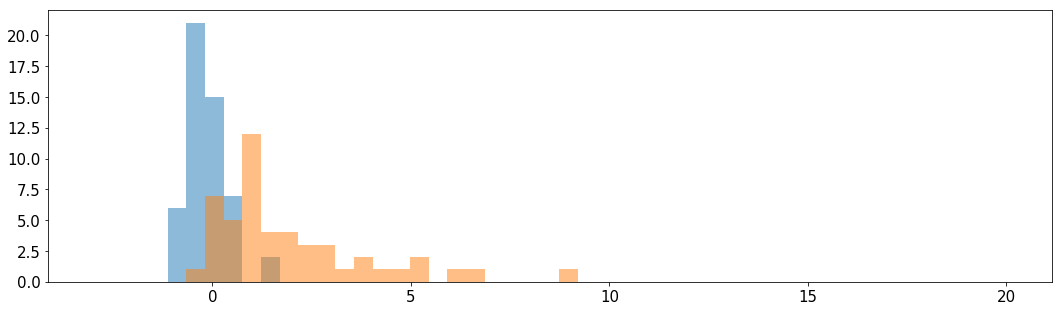

In [12]:
bins = np.linspace(-3, 20, 50)
idx = 3
mask = np.array(mtest)==0
plt.hist(sx_test[mask, idx], bins=bins, alpha=.5);
mask = np.array(mtest)==1
plt.hist(sx_test[mask, idx], bins=bins, alpha=.5);

## Set up the NN and train it 

In [13]:
model = ClassificationMDN(n_input=sx.shape[1], n_hidden_units=100, n_hidden_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, optimizer, verbose=True, classification=True)

n_epochs = 10
n_minibatch = int(ntrain / 100)

training: 100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


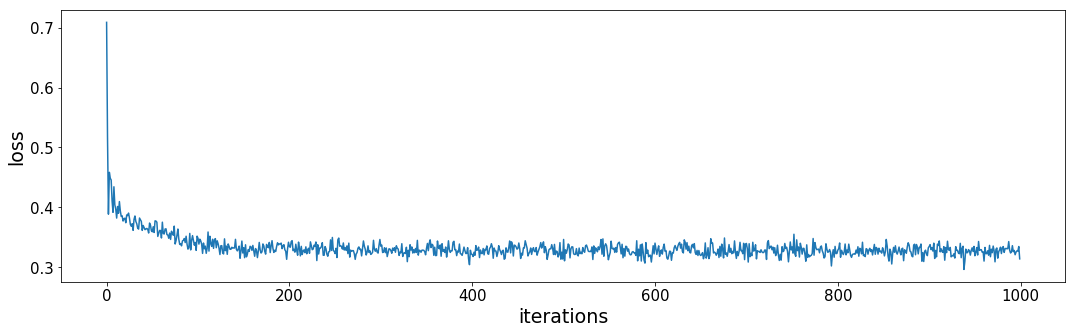

In [14]:
# train with training data
loss_trace = trainer.train(sx_zt, m, n_epochs=n_epochs, n_minibatch=n_minibatch)
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

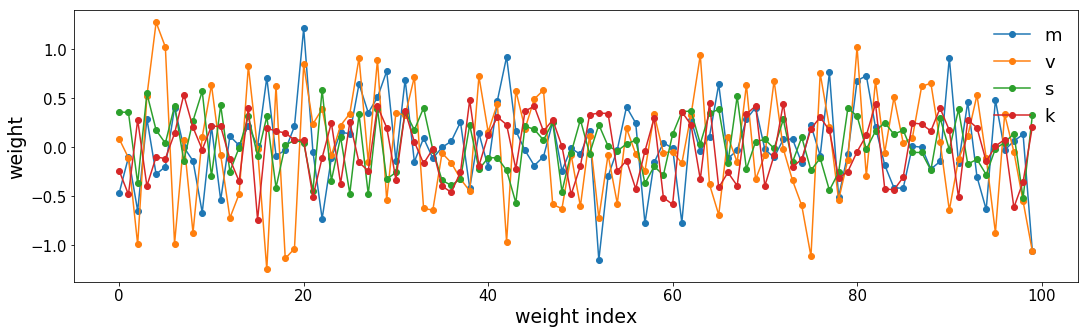

In [15]:
for param in model.parameters():
#     print(type(param.data), param.size(), param.data)
    plt.plot(param.data.numpy(), '-o')
    plt.xlabel('weight index')
    plt.ylabel('weight')
    plt.legend(['m', 'v', 's', 'k'])
    break

### Visualize the NN input output function

In [17]:
# # normalize 
# stats_space = np.linspace(0, 10, 100)
# sx_vis, training_norm = normalize(stats_space, training_norm)
# # predict probs of entire range
# probs_vis = model.predict(sx_vis.reshape((stats_space.size, 1)))

In [19]:
# fig, ax = plt.subplots(figsize=(18, 5))
# ax.plot(stats_space, prior_m0.pdf(stats_space), label='m0 prior')
# ax.plot(stats_space, prior_m1.pdf(stats_space), label='m1 prior')
# ax.plot(stats_space, probs_vis[:, 0], label='NN output: $p(m0 \;|\; x))$')
# ax.plot(stats_space, probs_vis[:, 1], label='NN output: $p(m1 \;|\; x))$')
# ax.legend();

## Approximate the exact posterior

In [20]:
def marli_lapace(scale, data, model_mean, prior): 
    likelihood = np.prod(scipy.stats.laplace.pdf(data, loc=model_mean, scale=scale))
    return likelihood * prior.pdf(scale)

def marli_normal(scale, data, model_mean, prior): 
    likelihood = np.prod(scipy.stats.norm.pdf(data, loc=model_mean, scale=scale))
    return likelihood * prior.pdf(scale**2)

# def marginal_likelihood_integrant(mu, xo, model_distr, model_std, prior_distr): 
#     return np.prod(model_distr.pdf(xo, loc=mu, scale=model_distr.std()) * prior_distr.pdf(mu)

In [21]:
marli0 = np.array([integrate.quad(marli_normal, 0, 4, 
                                  args=(xo, m0.mu, prior_m0))[0] for xo in xtest])
marli1 = np.array([integrate.quad(marli_lapace, 0, 4, 
                                  args=(xo, m1.mu, prior_m1))[0] for xo in xtest])

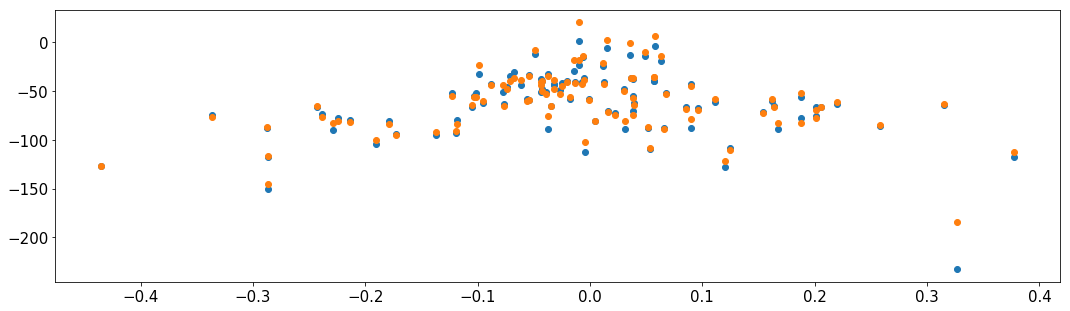

In [22]:
plt.plot(sx_test[:, 0], np.log(marli0), 'o')
plt.plot(sx_test[:, 0], np.log(marli1), 'o')

In [23]:
pphat = model.predict(sx_test_zt)[:, 1]

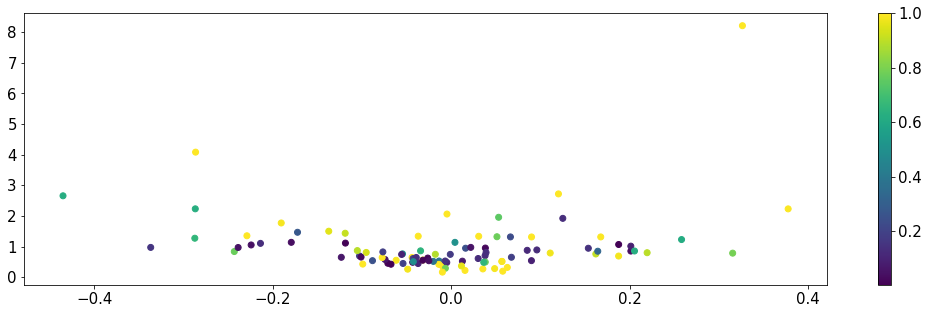

In [24]:
pp0 = marli0 / (marli0 + marli1)
pp1 = marli1 / (marli0 + marli1)
mask = np.array(mtest)==1
# plt.scatter(x=sx_test[mask, 0], y=np.log(sx_test[mask, 1]), c=pp0[mask], marker='o')
plt.scatter(x=sx_test[:, 0], y=(sx_test[:, 1]), c=pp1, marker='o')
plt.colorbar()

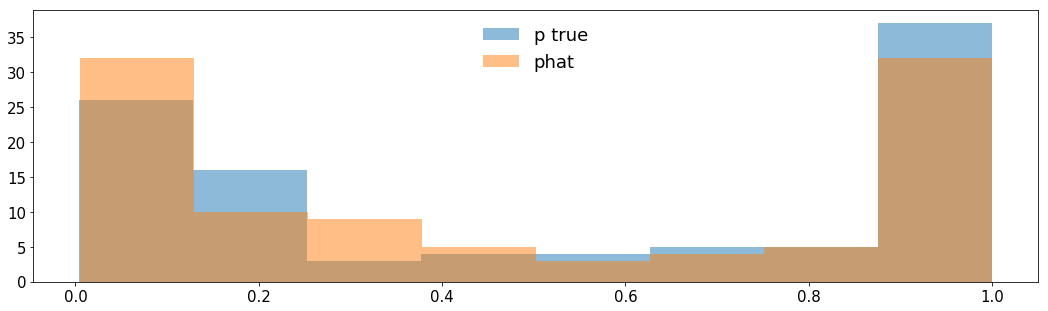

In [25]:
plt.hist(pp1, bins='auto', label='p true', alpha=.5);
plt.hist(pphat, bins='auto', label='phat', alpha=.5);
plt.legend()

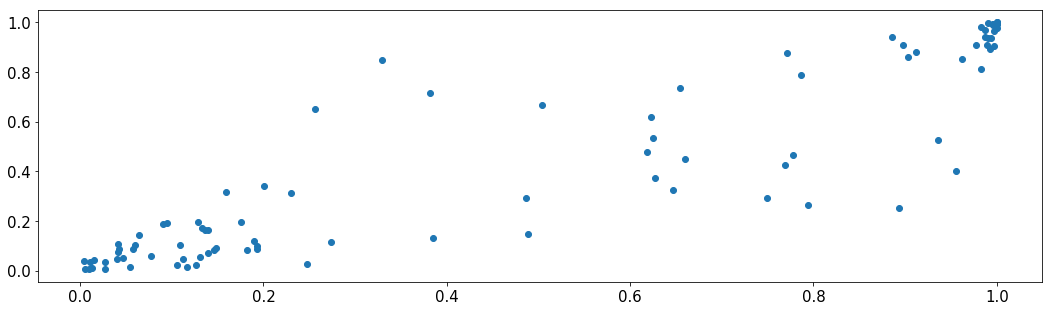

In [26]:
plt.plot(pp1, pphat, 'o')

In [27]:
np.abs(np.array(mtest) - pphat).mean()

0.18451907228212805

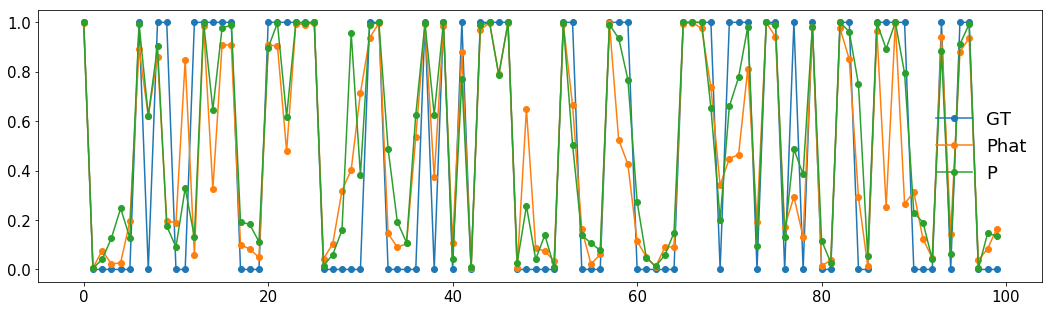

In [28]:
plt.plot(mtest, '-o', label='GT')
plt.plot(model.predict(sx_test_zt)[:, 1], '-o', label='Phat')
plt.plot(pp1, '-o', label='P')
plt.legend()